In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [4]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_airfoil(x, y, figsize=(12,4)):
    """Plot the airfoil desribed by nodes (x[i], y[i]) """

    plt.figure(figsize=figsize)
    plt.plot(x,y)

    ax = plt.gca()
    ax.set_ylim([-0.1, 0.1])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")  
    ax.set_title("Airfoil")

    plt.show()

In [500]:
def plot_cp_distribution(x, cp, title="Cp Distribution", figsize=(8,6)):
    """Plot the Cp distribution of one simulation
    
    Don't worry if you have never seen a Cp distribution. You can just treat it as an dimensionless output vector of size 192"""

    plt.figure(figsize=figsize)
    plt.plot(x, cp, "o-")

    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1]) # invert the y-axis of the plot
    ax.grid(True)
    ax.set_xlabel("X")
    ax.set_ylabel("Cp")

    ax.set_title(title)

    plt.show()


In [540]:
def predictd(): 
    # load input data
    flow_conditions = pd.read_csv("flow_conditions.csv", index_col=0)

    # load simulation results
    surface_flow_sim_results = pd.read_csv("surface_flow_sim_results.csv", index_col=0)

    nodes_x = surface_flow_sim_results["x"][:192].values
    nodes_y = surface_flow_sim_results["y"][:192].values


    Cp = surface_flow_sim_results["Pressure_Coefficient"].values
    Cp = Cp.reshape(-1,192)
    Y = Cp # this is the output matrix from the assignment
    
    N_data = 80 # amount of prediction
    X = flow_conditions[["Ma", "AoA"]].values
    X_data_MA = np.vander(X[:,0], 9)
    X_data_AOA = np.vander(X[:,1], 9)
    X_data = X_data_MA+X_data_AOA

    y_aftertrans,_,_,_ = SVD(Y)
    
    W_mle = np.linalg.inv(X_data.T @ X_data) @ X_data.T @ y_aftertrans
    y_pred_mle = X_data[0:N_data,:] @ W_mle #get the prediction 
    #print(y_pred_mle)
    dev = np.empty([1,7])
    relat_error =  np.empty([1,7])
    
    for i in range(7):
        sigma_e_mle = np.sqrt(np.sum(np.power(y_aftertrans[0:N_data][:,i] - y_pred_mle[:,i], 2)) / N_data)
        dev[0,i] = sigma_e_mle
        relat_error[0,i] = np.average(np.abs(y_aftertrans[0:N_data][:,i] -  y_pred_mle[:,i]) / y_aftertrans[0:N_data][:,i], 
                                      axis=0)
    #print(dev)
    print(relat_error)
    return y_pred_mle,relat_error

In [592]:
def SVD(x_train):    
    x_train_mean = x_train.mean(axis=0)
    x_train_centered = x_train - x_train_mean
    U, s, Vt = np.linalg.svd(x_train_centered/np.sqrt(len(x_train)))
    U.shape, Vt.shape
    lambda_svd = s**2
    modes_svd = Vt
    
#     plt.plot(np.cumsum(lambda_svd)/np.sum(lambda_svd))
#     plt.axhline(0.99, ls=":")

    lambda_svd_sum = np.sum(lambda_svd)
    lambda_svd_cumsum = np.cumsum(lambda_svd)
    for i in range(20):
        print(i, lambda_svd[i], lambda_svd_cumsum[i]/lambda_svd_sum)
    r = 7
    x_train_compressed = x_train @ Vt[:r].T
    x_restored = x_train_compressed @ Vt[:r] + x_train_mean
#     print("after transfer ",'\n',x_train_compressed)
#     print("restored ",'\n',x_restored)
    return x_train_compressed,modes_svd[:r].T,x_restored,x_train_mean

In [627]:
def main():
    # load input data
    flow_conditions = pd.read_csv("flow_conditions.csv", index_col=0)
    print("flow_conditions:")
    #print(flow_conditions)
    
    # load simulation results
    surface_flow_sim_results = pd.read_csv("surface_flow_sim_results.csv", index_col=0)
    print("surface_flow_sim_results:")    
    #print(surface_flow_sim_results)

    # get the coordinates of the airfoil mesh nodes
    # (the geometry does not change between simulation runs, so the first 192 values are enough)
    nodes_x = surface_flow_sim_results["x"][:192].values
    nodes_y = surface_flow_sim_results["y"][:192].values

    #plot_airfoil(nodes_x, nodes_y)

    # the only output variable we care about in this assignment is the pressure coefficient Cp
    # we can extract the values and turn the pandas.Series object into a numpy array (2D matrix of size n_sim x n_nodes)
    Cp = surface_flow_sim_results["Pressure_Coefficient"].values
    Cp = Cp.reshape(-1,192)
    print("Cp.shape:", Cp.shape)
    Y = Cp # this is the output matrix from the assignment

    # the same can be done with the input data (flow conditions)
    X = flow_conditions[["Ma", "AoA"]].values
    print("X.shape:", X.shape)
   
    # plot the Cp distribution of some simulation results
#     plot_cp_distribution(nodes_x, Cp[0], title="Cp Distribution i=0 at $M_{\infty}$="+f"{X[0,0]} and AoA={X[0,1]} [deg.]")
    #plot_cp_distribution(nodes_x, Cp[1], title="Cp Distribution i=1 at $M_{\infty}$="+f"{X[1,0]} and AoA={X[1,1]} [deg.]")
#     plot_cp_distribution(nodes_x, Cp[100], title="Cp Distribution i=100 at $M_{\infty}$="+f"{X[100,0]} and AoA={X[100,1]} [deg.]")
    
    # now do the analysis...
    # version 1 data been normalized
#     scaler  = StandardScaler().fit(Y)
#     Xy = scaler.fit_transform(Y)
    
    
#     #get the original value 
#     #Yx = scaler.inverse_transform(Xy)
#     #print(Yx)
    
#     #print(cov_ma)
#     pca = PCA(n_components=8)
#     cov_ma = np.cov(Xy.T)
#     eigval,eigvec = np.linalg.eig(cov_ma)
#     #print(eigval.argsort()[::-1])
    
#     principalComponents = pca.fit_transform(Xy)
#     principalDf = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 
#                                                                        'principal component 2',
#                                                                        'principal component 3',
#                                                                        'principal component 4',
#                                                                        'principal component 5',
#                                                                        'principal component 6',
#                                                                        'principal component 7',
#                                                                        'principal component 8'])
    #print("aftertransfer",principalDf)
#     tranmat = eigvec[:,0:8] #you can set the new matrix s dim here
#     Xy_aftertrans = Xy@tranmat
#     Xy_aftertrans = Xy_aftertrans.astype("double")
#     print(Xy_aftertrans)
    
#     plot_cp_distribution(nodes_x[0:8], Xy_aftertrans[0], title="Cp Distribution i=0 at $M_{\infty}$="+f"{X[0,0]} and AoA={X[0,1]} [deg.]")
    
#     sumofeig_val = 0
#     for i in range(8):   #you can set the new matrix s dim here
#         sumofeig_val = eigval[i] + sumofeig_val
#     energy = sumofeig_val/np.sum(eigval)
#     print(energy)



    a,b,c,d = SVD(Y)
    pre_result,_ = predictd()
    
    #plot_cp_distribution(nodes_x, c[1], title="Restored Cp Distribution i=1 at $M_{\infty}$="+f"{X[1,0]} and AoA={X[1,1]} [deg.]")
    
    relav_err = np.abs(Cp[1]-c[1])/Cp[1]
    plot_err(nodes_x, relav_err, title="relative errot at i=1 at $M_{\infty}$="+f"{X[1,0]} and AoA={X[1,1]} [deg.]")

  


    
    # output the results to csv
    Cp_output_data = np.zeros((80,192))   # change this to the true output data generated from 'flow_conditions_test.csv' 
    Cp_output_data = pre_result@b.T+d
    pd.DataFrame(Cp_output_data).to_csv("cp_output_data.csv")
    relative_err = np.zeros(192,)
    print(b.shape)
    for i in range(192):
        relative_err[i] = np.average(np.abs(Cp_output_data[0:80][:,i] -  Cp[0:80][:,i]) / Cp[0:80][:,i], 
                                      axis=0)
        



    plt.scatter(nodes_x, relative_err,s = 1)
    plt.ylim(-1,1)

flow_conditions:
surface_flow_sim_results:
Cp.shape: (160, 192)
X.shape: (160, 2)
0 3.9237759765105036 0.8352444237692993
1 0.4553318289710312 0.9321697766409868
2 0.12695482337696878 0.9591943338356438
3 0.07183109357252208 0.9744848398989017
4 0.04780717618062654 0.9846614344751639
5 0.019707530426378163 0.9888565274145764
6 0.015546927098673488 0.9921659630815595
7 0.009236572938055776 0.9941321293681756
8 0.006879382389654245 0.9955965263710458
9 0.004496450074653418 0.9965536745043986
10 0.003123623195479489 0.9972185923976726
11 0.0029438648209224256 0.9978452455732683
12 0.0024314239616286056 0.998362816738882
13 0.0015112442370216314 0.9986845115373318
14 0.0012992591151839469 0.998961081590639
15 0.001048568658538289 0.9991842877905408
16 0.0009626002548224547 0.9993891941103644
17 0.0006301981024268716 0.9995233428115322
18 0.0004894012711331734 0.9996275204417402
19 0.00047928042033417464 0.9997295436716348
0 3.9237759765105036 0.8352444237692993
1 0.4553318289710312 0.93216

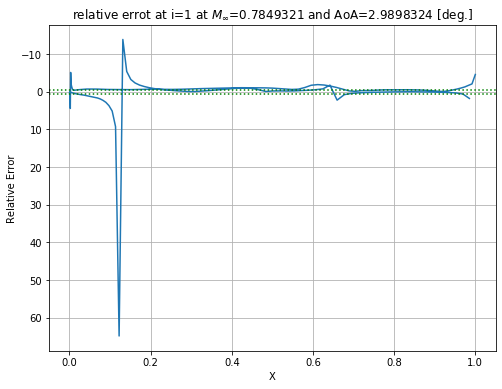

(192, 7)


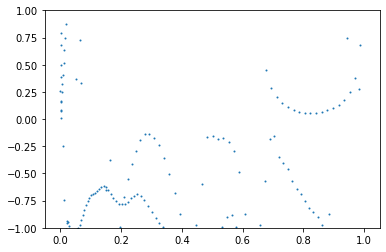

In [628]:

if __name__ == "__main__":
    main()

In [626]:
def plot_err(x, cp, title="Relative Error", figsize=(8,6)):
    """Plot the Cp distribution of one simulation
    
    Don't worry if you have never seen a Cp distribution. You can just treat it as an dimensionless output vector of size 192"""

    plt.figure(figsize=figsize)
    plt.plot(x, cp, "-")
    plt.axhline(0.5, ls=":",color='green')
    plt.axhline(-0.5, ls=":",color='green')
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1]) # invert the y-axis of the plot
    ax.grid(True)
    ax.set_xlabel("X")
    ax.set_ylabel("Relative Error") 
    ax.set_title(title)

    plt.show()
